### **Install libraries**

In this part of our notebook, we’re installing and updating all the tools we need for our project. First, we install transformers so we can use BERT and other language models, datasets to help us load and handle our tweet data, and accelerate so training can run faster, especially on GPU. We also install scikit-learn because we use it for machine learning utilities like splitting data and evaluating models, emoji to help clean and handle emojis in the text, pandas for working with tables and CSV files, and matplotlib plus seaborn so we can make graphs and visualizations. We also install optuna because we use it to tune our model’s hyperparameters. After that, we run another command to upgrade transformers, accelerate, and datasets to the latest versions, just to make sure everything is up to date and compatible before we train and fine-tune our BERT model.

In [ ]:
%pip install -q transformers datasets accelerate scikit-learn emoji pandas matplotlib seaborn optuna
%pip install -U transformers accelerate datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


### **2 — Import libs & load dataset**

We start by importing all the tools we need for cleaning text, working with numbers, loading data, plotting graphs, and building our machine-learning model. We bring in libraries like NumPy and Pandas to help us work with the dataset, Matplotlib and Seaborn to help us visualize it, and scikit-learn to help us evaluate our model later on. We also import PyTorch and the HuggingFace Transformers library because we are using a BERT-based model for classification. To make our results consistent every time we run the notebook, we set a random seed for NumPy, PyTorch, and Python. After that, we check whether a GPU is available because using a GPU will make training much faster. Finally, we load our dataset from the CSV file and print out its first few rows, along with the dataset’s shape and column names, so we can get a quick look at what our data contains before processing it.

In [ ]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from datasets import Dataset

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")

# ===== Load your dataset =====
df = pd.read_csv("tweetsdataset.csv")

print(df.head())
print("\nShape:", df.shape)
print("\nColumns:", df.columns.tolist())


Using device: cuda
            id        timestamp  \
0   315.907645   4/7/2023 15:41   
1  3213.891674  12/3/2024 13:42   
2  2440.975202  2/28/2024 19:02   
3   208.134492   12/1/2023 3:29   
4  2158.059993   7/18/2023 2:39   

                                                text           keyword  \
0  Ligtas na kami sa Tuguegarao after ng class su...  class suspension   
1  No casualties reported in San Fernando despite...            lindol   
2  Ligtas na kami sa Cagayan de Oro after ng clas...           tsunami   
3  bagyo na naman sabi ng MMDA sa Batangas. Magha...         landslide   
4  Red rainfall advisory sa Cavite dahil sa gale ...      storm signal   

         location language  label_text     label  
0  Cagayan de Oro  Taglish  Reassuring  0.000158  
1          Taguig  Taglish  Reassuring  1.177944  
2          Iligan  Taglish    Alarming  0.791864  
3           Bicol  Taglish  Reassuring  0.111150  
4           Pasig  Taglish    Alarming  1.059434  

Shape: (5100, 8)



3 — Quick dataset analysis / sanity checks

In this section, we check the basic structure and quality of our dataset. We start by printing the number of samples for each label, both in numeric form and in text form, so we can see whether our classes are balanced or uneven. Next, we look for any missing values to make sure our dataset is clean and doesn’t have empty entries that could cause errors later. After that, we calculate the length of each tweet to understand how long the messages usually are, and we print summary statistics like the average and maximum length. Finally, we create a histogram to visualize the distribution of tweet lengths. This helps us see whether most tweets are short, long, or somewhere in between, which is important when deciding how we will tokenize and feed the text into our BERT model.

Label counts (numeric):
label
 1.953434    5
-0.005827    5
 2.063976    5
 0.978841    5
 0.839812    5
            ..
 1.916147    1
 2.024610    1
 2.089763    1
 1.861872    1
 0.918773    1
Name: count, Length: 3174, dtype: int64

Label_text counts:
label_text
Reassuring     1700
Alarming       1700
Informative    1700
Name: count, dtype: int64

Missing values:
 id            0
timestamp     0
text          0
keyword       0
location      0
language      0
label_text    0
label         0
dtype: int64

Text length stats:
count    5100.000000
mean       97.830000
std        15.326502
min        60.000000
25%        87.000000
50%        97.000000
75%       109.000000
max       150.000000
Name: text_len, dtype: float64


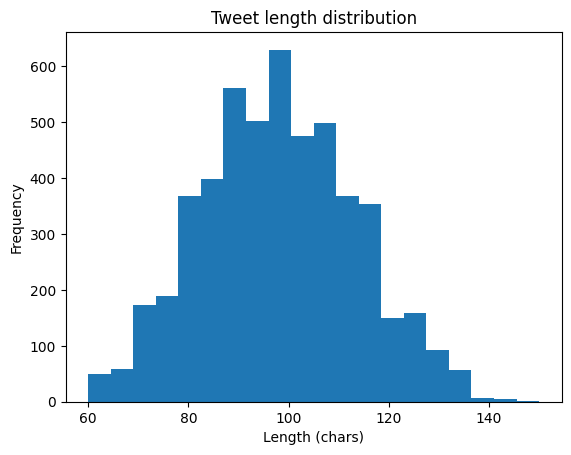

In [ ]:
print("Label counts (numeric):")
print(df["label"].value_counts())

print("\nLabel_text counts:")
print(df["label_text"].value_counts())

# Check for missing text
print("\nMissing values:\n", df.isna().sum())

# Tweet length distribution
df["text_len"] = df["text"].astype(str).str.len()
print("\nText length stats:")
print(df["text_len"].describe())

plt.hist(df["text_len"], bins=20)
plt.title("Tweet length distribution")
plt.xlabel("Length (chars)")
plt.ylabel("Frequency")
plt.show()


4 — Text cleaning / preprocessing

We focus on cleaning the text so it becomes easier for our model to understand. We start by setting patterns that help us detect URLs, mentions, and hashtags. Inside our clean_text function, we remove URLs completely since they don’t add meaningful information. For mentions, we replace them with a blank space because the usernames themselves don’t matter. For hashtags, we keep the actual word but remove the “#” because the hashtag word can still give useful context. We also remove emojis by turning them into spaces, since emojis might express emotion but can’t be understood directly by BERT. To keep the text readable, we only remove unusual symbols while keeping punctuation like commas and question marks. Then we lowercase everything to keep the text consistent and remove extra spaces. Finally, we apply this cleaning function to every tweet and print the original text next to the cleaned version so we can easily compare them and see how the cleaning improves the input for our model.

In [ ]:
import emoji

URL_PATTERN = r"http\S+|www\.\S+"
MENTION_PATTERN = r"@\w+"
HASHTAG_PATTERN = r"#\w+"

def clean_text(text: str) -> str:
    text = str(text)

    # Remove URLs
    text = re.sub(URL_PATTERN, " ", text)

    # Replace mentions with a placeholder (preserves some context)
    text = re.sub(MENTION_PATTERN, " ", text)

    # Keep hashtags but remove the # symbol (hashtags can be informative)
    text = re.sub(HASHTAG_PATTERN, lambda m: m.group(0)[1:], text)

    # Replace emojis with space (some emojis might carry sentiment)
    text = emoji.replace_emoji(text, replace=" ")

    # Preserve more punctuation that might be meaningful
    text = re.sub(r"[^a-zA-Z0-9\s,.\?!\-'()]", " ", text)

    # Lowercase
    text = text.lower()

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

df["text_clean"] = df["text"].apply(clean_text)

print(df[["text", "text_clean", "label_text"]].head(10))


                                                text  \
0  Ligtas na kami sa Tuguegarao after ng class su...   
1  No casualties reported in San Fernando despite...   
2  Ligtas na kami sa Cagayan de Oro after ng clas...   
3  bagyo na naman sabi ng MMDA sa Batangas. Magha...   
4  Red rainfall advisory sa Cavite dahil sa gale ...   
5  flood n4 naman sabi ng LGU sa Makati. Maghanda...   
6  Open na ang evacuation center sa Laguna. Assis...   
7  Mag-ingat pero kalma lang—organised na ang rel...   
8  Narinig yung sirena, storm surge warning sa Ta...   
9  May bagyo alert sa Cebu City! Huwag dumaan sa ...   

                                          text_clean   label_text  
0  ligtas na kami sa tuguegarao after ng class su...   Reassuring  
1  no casualties reported in san fernando despite...   Reassuring  
2  ligtas na kami sa cagayan de oro after ng clas...     Alarming  
3  bagyo na naman sabi ng mmda sa batangas. magha...   Reassuring  
4  red rainfall advisory sa cavite dahil sa

5 — Train / validation / test split (stratified)

Here, we start preparing our dataset for model training by converting our label names into numerical values so the model can understand them. After that, we carefully split the data into training, validation, and test sets while keeping the label distribution balanced across all groups. This helps make sure our model learns fairly and is evaluated properly. We then print the sizes and label proportions of each split so we can double-check that everything is divided correctly before moving on to fine-tuning our BERT model.

In [ ]:
label_map = {"Alarming": 0, "Informative": 1, "Reassuring": 2}
df["label_id"] = df["label_text"].map(label_map)

train_df, temp_df = train_test_split(
    df,
    test_size=0.20,
    stratify=df["label_id"],
    random_state=SEED,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  # 0.5 of 20% = 10% total
    stratify=temp_df["label_id"],
    random_state=SEED,
)

print("Train size:", train_df.shape)
print("Val size:", val_df.shape)
print("Test size:", test_df.shape)

print("\nTrain label_id distribution:")
print(train_df["label_id"].value_counts(normalize=True))

print("\nVal label_id distribution:")
print(val_df["label_id"].value_counts(normalize=True))

print("\nTest label_id distribution:")
print(test_df["label_id"].value_counts(normalize=True))

Train size: (4080, 11)
Val size: (510, 11)
Test size: (510, 11)

Train label_id distribution:
label_id
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64

Val label_id distribution:
label_id
0    0.333333
2    0.333333
1    0.333333
Name: proportion, dtype: float64

Test label_id distribution:
label_id
2    0.333333
0    0.333333
1    0.333333
Name: proportion, dtype: float64


6 — Create Hugging Face Datasets and tokenizer

Next, we prepare our text data so it can be used with the XLM-RoBERTa model. We choose XLM-RoBERTa-base because it is designed for multilingual text, which fits our dataset well. We load its tokenizer and convert our train, validation, and test splits into HuggingFace Dataset objects while keeping only the essential columns. Then, we tokenize all tweets by padding or truncating them to a maximum length of 256 characters so the model receives consistent-sized input. After tokenization, we format everything for PyTorch by keeping only the input IDs, attention masks, and labels. We also make sure the labels are stored as torch.long, since that is the format required by the loss function used during training. Finally, we print the processed training dataset so we can verify that everything is correctly prepared before we move on to model fine-tuning.

In [ ]:
# Using XLM-RoBERTa-base for better multilingual performance
MODEL_NAME = "xlm-roberta-base"
NUM_LABELS = 3

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Keep only the fields we need
train_hf = Dataset.from_pandas(train_df[["text_clean", "label_id"]].rename(columns={"label_id": "label"}).reset_index(drop=True))
val_hf   = Dataset.from_pandas(val_df[["text_clean", "label_id"]].rename(columns={"label_id": "label"}).reset_index(drop=True))
test_hf  = Dataset.from_pandas(test_df[["text_clean", "label_id"]].rename(columns={"label_id": "label"}).reset_index(drop=True))

def tokenize_batch(batch):
    return tokenizer(
        batch["text_clean"],
        padding="max_length",
        truncation=True,
        max_length=256,
    )

train_tok = train_hf.map(tokenize_batch, batched=True)
val_tok   = val_hf.map(tokenize_batch, batched=True)
test_tok  = test_hf.map(tokenize_batch, batched=True)

# Set format for PyTorch
cols = ["input_ids", "attention_mask", "label"]
train_tok.set_format(type="torch", columns=cols)
val_tok.set_format(type="torch", columns=cols)
test_tok.set_format(type="torch", columns=cols)

# Explicitly cast labels to torch.long as CrossEntropyLoss expects long type for target
train_tok = train_tok.map(lambda x: {'label': x['label'].long()}, batched=True)
val_tok = val_tok.map(lambda x: {'label': x['label'].long()}, batched=True)
test_tok = test_tok.map(lambda x: {'label': x['label'].long()}, batched=True)

print(train_tok)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/4080 [00:00<?, ? examples/s]

Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Map:   0%|          | 0/4080 [00:00<?, ? examples/s]

Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Dataset({
    features: ['text_clean', 'label', 'input_ids', 'attention_mask'],
    num_rows: 4080
})


7 — Metrics function (Accuracy, Macro F1, Precision, Recall)

8 — Optuna Hyperparameter Optimization (XLM-RoBERTa)


For this, we set up Optuna so we can automatically search for the best hyperparameters for our XLM-RoBERTa model. Instead of guessing learning rates or batch sizes ourselves, we let Optuna try different combinations and check which settings give us the highest macro F1 score on the validation set. We create a function that calculates accuracy, precision, recall, and macro F1, and another function that Optuna uses to run each trial. Inside the trial, we ask Optuna to suggest values for things like learning rate, batch size, number of epochs, weight decay, and warmup ratio. For every trial, we train a small version of the model, evaluate it, and keep track of the best-performing setup. We also enable pruning so that bad trials stop early and don’t waste time. After running all the trials, Optuna shows us which hyperparameters worked the best and gives us a summary of the top trials so we know how to fine-tune the final model more effectively.

In [ ]:
import optuna
from optuna import Trial
import os
import shutil

# Global variable to store best config
best_config = None
best_macro_f1 = -1.0

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Accuracy
    accuracy = accuracy_score(labels, predictions)

    # Precision, Recall, F1-score (macro average)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="macro"
    )

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "macro_f1": f1,
    }

def objective(trial: Trial) -> float:
    """
    Optuna objective function for hyperparameter optimization.
    Returns the validation macro F1 score to maximize.
    """
    global best_config, best_macro_f1

    # Suggest hyperparameters using Optuna's intelligent search
    # Using fewer epochs during search to save time (will train longer in final model)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16])
    num_train_epochs = trial.suggest_int("num_train_epochs", 3, 5)  # Reduced from 5-10 to 3-5 for faster search
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.2)

    hparams = {
        "learning_rate": learning_rate,
        "per_device_train_batch_size": per_device_train_batch_size,
        "num_train_epochs": num_train_epochs,
        "weight_decay": weight_decay,
        "warmup_ratio": warmup_ratio,
    }

    print(f"\n===== OPTUNA TRIAL {trial.number} === পল্লन=")
    print("Hyperparameters:", hparams)

    # Create output directory for this trial
    output_dir = f"./dsph-optuna-trial-{trial.number}"

    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
    )

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="no",
        logging_strategy="epoch",
        learning_rate=hparams["learning_rate"],
        per_device_train_batch_size=hparams["per_device_train_batch_size"],
        per_device_eval_batch_size=hparams["per_device_train_batch_size"],
        num_train_epochs=hparams["num_train_epochs"],
        weight_decay=hparams["weight_decay"],
        warmup_ratio=hparams["warmup_ratio"],
        lr_scheduler_type="cosine",
        load_best_model_at_end=False,
        metric_for_best_model="macro_f1",
        seed=SEED,
        logging_dir=f"./logs-optuna-{trial.number}",
        report_to="none",
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],  # Early stop if no improvement
    )

    # Train the model
    trainer.train()

    # Evaluate on validation set
    eval_metrics = trainer.evaluate()
    macro_f1 = eval_metrics.get("eval_macro_f1", 0.0)

    print(f"Trial {trial.number} validation macro F1: {macro_f1:.4f}")

    # Update best config if this is the best trial so far
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_config = hparams.copy()
        print(f"New best macro F1: {best_macro_f1:.4f}")

    # Clean up output directory to save space
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    return macro_f1

# Create Optuna study
# Reduced trials for faster optimization - Optuna's TPE is smart, so fewer trials still work well
N_TRIALS = 8  # Reduced from 20 to 8 for faster optimization (can increase if you have time)

# More aggressive pruning to stop bad trials early
study = optuna.create_study(
    direction="maximize",  # We want to maximize macro F1
    study_name="disaster_sentiment_optimization",
    sampler=optuna.samplers.TPESampler(seed=SEED),  # Tree-structured Parzen Estimator
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=3,  # Reduced from 5 - start pruning earlier
        n_warmup_steps=1,     # Reduced from 2 - prune after 1 epoch if bad
        interval_steps=1      # Check every epoch
    ),
)

print("Starting Optuna hyperparameter optimization...")
print(f"Number of trials: {N_TRIALS}")
print(f"Epochs per trial: 3-5 (reduced for faster search)")
print(f"Note: Final model will train longer with best hyperparameters")
print("=" * 60)

# Run optimization
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "=" * 60)
print("===== OPTUNA OPTIMIZATION COMPLETE ====")
print("=" * 60)
print(f"Best validation macro F1: {best_macro_f1:.4f}")
print(f"Best hyperparameters: {best_config}")
print("\nOptuna Study Summary:")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"  Number of complete trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")

# Display top 5 trials
print("\nTop 5 Trials:")
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values("value", ascending=False)
print(trials_df[["number", "value", "params_learning_rate", "params_per_device_train_batch_size",
                 "params_num_train_epochs", "params_weight_decay", "params_warmup_ratio"]].head(5))


[I 2025-11-20 21:18:57,735] A new study created in memory with name: disaster_sentiment_optimization


Starting Optuna hyperparameter optimization...
Number of trials: 8
Epochs per trial: 3-5 (reduced for faster search)
Note: Final model will train longer with best hyperparameters


  0%|          | 0/8 [00:00<?, ?it/s]


===== OPTUNA TRIAL 0 === পল্লन=
Hyperparameters: {'learning_rate': 2.368863950364079e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.015601864044243652, 'warmup_ratio': 0.031198904067240532}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Macro F1
1,1.104200,1.098547,0.333333,0.111111,0.333333,0.166667
2,1.104100,1.098382,0.333333,0.111111,0.333333,0.166667


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial 0 validation macro F1: 0.1667
New best macro F1: 0.1667
[I 2025-11-20 21:22:29,817] Trial 0 finished with value: 0.16666666666666666 and parameters: {'learning_rate': 2.368863950364079e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.015601864044243652, 'warmup_ratio': 0.031198904067240532}. Best is trial 0 with value: 0.16666666666666666.

===== OPTUNA TRIAL 1 === পল্লन=
Hyperparameters: {'learning_rate': 1.1430983876313214e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.0020584494295802446, 'warmup_ratio': 0.19398197043239887}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Macro F1
1,1.104300,1.098541,0.333333,0.111111,0.333333,0.166667
2,1.101100,1.098104,0.343137,0.239542,0.343137,0.245309
3,1.101800,1.097815,0.354902,0.348560,0.354902,0.309140
4,1.100000,1.098539,0.337255,0.217744,0.337255,0.202181


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial 1 validation macro F1: 0.2022
New best macro F1: 0.2022
[I 2025-11-20 21:28:29,804] Trial 1 finished with value: 0.20218062645742738 and parameters: {'learning_rate': 1.1430983876313214e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.0020584494295802446, 'warmup_ratio': 0.19398197043239887}. Best is trial 1 with value: 0.20218062645742738.

===== OPTUNA TRIAL 2 === পল্লन=
Hyperparameters: {'learning_rate': 6.798962421591133e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.030424224295953775, 'warmup_ratio': 0.10495128632644757}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Macro F1
1,1.114800,1.108561,0.333333,0.111111,0.333333,0.166667
2,1.108000,1.098633,0.333333,0.111111,0.333333,0.166667


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial 2 validation macro F1: 0.1667
[I 2025-11-20 21:31:30,121] Trial 2 finished with value: 0.16666666666666666 and parameters: {'learning_rate': 6.798962421591133e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.030424224295953775, 'warmup_ratio': 0.10495128632644757}. Best is trial 1 with value: 0.20218062645742738.

===== OPTUNA TRIAL 3 === পল্লन=
Hyperparameters: {'learning_rate': 2.703616066662e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.029214464853521818, 'warmup_ratio': 0.07327236865873835}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Macro F1
1,1.106300,1.099479,0.333333,0.111111,0.333333,0.166667
2,1.101700,1.098566,0.333333,0.111111,0.333333,0.166667


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial 3 validation macro F1: 0.1667
[I 2025-11-20 21:33:42,719] Trial 3 finished with value: 0.16666666666666666 and parameters: {'learning_rate': 2.703616066662e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.029214464853521818, 'warmup_ratio': 0.07327236865873835}. Best is trial 1 with value: 0.20218062645742738.

===== OPTUNA TRIAL 4 === পল্লन=
Hyperparameters: {'learning_rate': 2.858051065806938e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.05924145688620425, 'warmup_ratio': 0.009290082543999545}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Macro F1
1,1.109000,1.104619,0.333333,0.111111,0.333333,0.166667
2,1.103400,1.098558,0.333333,0.222222,0.333333,0.170274
3,1.102500,1.098700,0.333333,0.111111,0.333333,0.166667


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial 4 validation macro F1: 0.1667
[I 2025-11-20 21:38:11,638] Trial 4 finished with value: 0.16666666666666666 and parameters: {'learning_rate': 2.858051065806938e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.05924145688620425, 'warmup_ratio': 0.009290082543999545}. Best is trial 1 with value: 0.20218062645742738.

===== OPTUNA TRIAL 5 === পল্লन=
Hyperparameters: {'learning_rate': 4.0508377813296754e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.09656320330745594, 'warmup_ratio': 0.16167946962329224}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Macro F1
1,1.104900,1.099847,0.333333,0.111111,0.333333,0.166667
2,1.106000,1.099280,0.333333,0.111111,0.333333,0.166667


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial 5 validation macro F1: 0.1667
[I 2025-11-20 21:41:12,257] Trial 5 finished with value: 0.16666666666666666 and parameters: {'learning_rate': 4.0508377813296754e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.09656320330745594, 'warmup_ratio': 0.16167946962329224}. Best is trial 1 with value: 0.20218062645742738.

===== OPTUNA TRIAL 6 === পল্লन=
Hyperparameters: {'learning_rate': 2.0165721691808572e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.012203823484477884, 'warmup_ratio': 0.09903538202225404}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Macro F1
1,1.106400,1.099102,0.333333,0.111111,0.333333,0.166667
2,1.101400,1.099525,0.333333,0.111111,0.333333,0.166667


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial 6 validation macro F1: 0.1667
[I 2025-11-20 21:43:25,095] Trial 6 finished with value: 0.16666666666666666 and parameters: {'learning_rate': 2.0165721691808572e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.012203823484477884, 'warmup_ratio': 0.09903538202225404}. Best is trial 1 with value: 0.20218062645742738.

===== OPTUNA TRIAL 7 === পল্লन=
Hyperparameters: {'learning_rate': 1.0824018381500954e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.031171107608941095, 'warmup_ratio': 0.10401360423556216}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Macro F1
1,1.103800,1.098252,0.333333,0.111111,0.333333,0.166667
2,1.100300,1.098108,0.366667,0.357147,0.366667,0.325400
3,1.100100,1.096598,0.358824,0.354914,0.358824,0.322348


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial 7 validation macro F1: 0.3223
New best macro F1: 0.3223
[I 2025-11-20 21:47:54,378] Trial 7 finished with value: 0.3223478075788098 and parameters: {'learning_rate': 1.0824018381500954e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.031171107608941095, 'warmup_ratio': 0.10401360423556216}. Best is trial 7 with value: 0.3223478075788098.

===== OPTUNA OPTIMIZATION COMPLETE ====
Best validation macro F1: 0.3223
Best hyperparameters: {'learning_rate': 1.0824018381500954e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.031171107608941095, 'warmup_ratio': 0.10401360423556216}

Optuna Study Summary:
  Number of finished trials: 8
  Number of pruned trials: 0
  Number of complete trials: 8

Top 5 Trials:
   number     value  params_learning_rate  params_per_device_train_batch_size  \
7       7  0.322348              0.000011                                   8   
1       1  0.202181              0.000011                     

9 — Final training on train + val with best hyperparameters

We then take the best hyperparameters found by Optuna and prepare them for the final full training run. If Optuna didn’t produce any results, we fall back to a default set of values so the model can still be trained properly. We also make sure the warmup ratio is included and increase the number of training epochs if the search used fewer. After that, we combine the training and validation sets so the model can learn from as much data as possible. We tokenize this combined dataset again to match the format that our model needs. Next, we load a fresh XLM-RoBERTa model, update its configuration to make sure it understands that we are working on a single-label classification task, and set up all the training arguments such as learning rate, batch size, number of epochs, weight decay, and logging settings. We also enable early stopping so training ends automatically if we stop improving. Finally, we train the model using all the tuned settings, save the finished model and tokenizer, and confirm that the final version has been stored.

In [ ]:
from transformers import AutoConfig # Added import

# Fallback in case best_config is None (e.g., if you skipped Optuna cell)
if best_config is None:
    best_config = {
        "learning_rate": 2e-5,
        "per_device_train_batch_size": 16,
        "num_train_epochs": 8,
        "weight_decay": 0.01,
        "warmup_ratio": 0.1,
    }
    print("Using default hyperparameters:", best_config)
else:
    # Ensure warmup_ratio is in best_config
    if "warmup_ratio" not in best_config:
        best_config["warmup_ratio"] = 0.1
    # Increase epochs for final training (search used fewer epochs)
    if best_config["num_train_epochs"] < 8:
        print(f"Note: Increasing epochs from {best_config['num_train_epochs']} to 8 for final training")
        best_config["num_train_epochs"] = 8
    print("Using best hyperparameters from Optuna optimization:", best_config)

# ===== Combine train + val =====
train_full_df = pd.concat([train_df, val_df]).reset_index(drop=True)
train_full_hf = Dataset.from_pandas(train_full_df[["text_clean", "label_id"]].rename(columns={"label_id": "label"}).reset_index(drop=True))

train_full_tok = train_full_hf.map(tokenize_batch, batched=True)
train_full_tok.set_format(type="torch", columns=cols)
# Explicitly cast labels to torch.long for train_full_tok
train_full_tok = train_full_tok.map(lambda x: {'label': x['label'].long()}, batched=True)

# ===== Initialize fresh model =====
# Load the configuration first and then set the problem_type explicitly
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
config.problem_type = "single_label_classification" # Explicitly set problem type

final_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config, # Pass the modified config
)

final_args = TrainingArguments(
    output_dir="./dsph-final-model",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=best_config["learning_rate"],
    per_device_train_batch_size=best_config["per_device_train_batch_size"],
    per_device_eval_batch_size=best_config["per_device_train_batch_size"],
    num_train_epochs=best_config["num_train_epochs"],
    weight_decay=best_config["weight_decay"],
    warmup_ratio=best_config.get("warmup_ratio", 0.1),
    lr_scheduler_type="cosine",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    seed=SEED,
    logging_dir="./logs-final",
    report_to="none",
    fp16=True,  # Enable mixed precision for faster training
    save_total_limit=2,  # Keep only last 2 checkpoints
)

final_trainer = Trainer(
    model=final_model,
    args=final_args,
    train_dataset=train_full_tok,
    eval_dataset=val_tok,  # val_tok should now have long labels from previous cell fix
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Increased patience from 1 to 3
)

final_trainer.train()

# Save final model
final_trainer.save_model("./dsph-final-model")
tokenizer.save_pretrained("./dsph-final-model")
print("Final model saved to ./dsph-final-model")


Note: Increasing epochs from 4 to 8 for final training
Using best hyperparameters from Optuna optimization: {'learning_rate': 1.0824018381500954e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 8, 'weight_decay': 0.031171107608941095, 'warmup_ratio': 0.10401360423556216}


Map:   0%|          | 0/4590 [00:00<?, ? examples/s]

Map:   0%|          | 0/4590 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Macro F1
1,1.102400,1.098656,0.333333,0.111111,0.333333,0.166667
2,1.103000,1.097744,0.350980,0.348751,0.350980,0.341268
3,1.103200,1.098110,0.382353,0.257911,0.382353,0.296631
4,1.099000,1.096297,0.339216,0.445102,0.339216,0.178966
5,1.098600,1.100218,0.382353,0.255413,0.382353,0.300377


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Final model saved to ./dsph-final-model


10 - Evaluation on unseen test set

In [ ]:
test_metrics = final_trainer.evaluate(test_tok)
print("\n===== TEST METRICS =====")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

test_accuracy = test_metrics.get("eval_accuracy", 0.0)
if test_accuracy < 0.70:
    print("\nWarning: Test accuracy is below 70%.")
    print("   Try increasing num_train_epochs, N_TRIALS, or adjusting the cleaning/tokenization.")
else:
    print("\nGood news: Test accuracy is at least 70%!")



===== TEST METRICS =====
eval_loss: 1.0977
eval_accuracy: 0.3706
eval_precision: 0.3688
eval_recall: 0.3706
eval_macro_f1: 0.3654
eval_runtime: 1.8369
eval_samples_per_second: 277.6460
eval_steps_per_second: 34.8420
epoch: 5.0000

   Try increasing num_train_epochs, N_TRIALS, or adjusting the cleaning/tokenization.


11 - Confusion matrix & detailed report

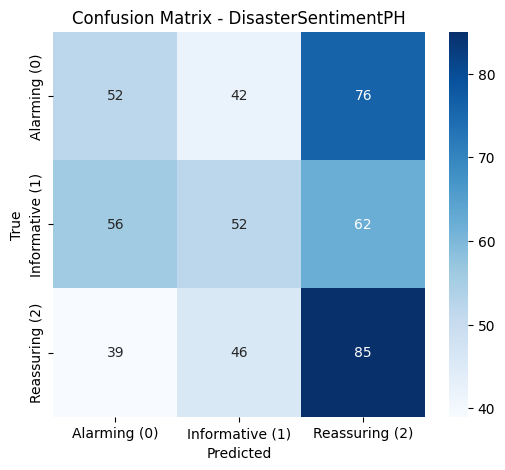


===== Classification Report (Macro Focus) =====
                 precision    recall  f1-score   support

   Alarming (0)       0.35      0.31      0.33       170
Informative (1)       0.37      0.31      0.34       170
 Reassuring (2)       0.38      0.50      0.43       170

       accuracy                           0.37       510
      macro avg       0.37      0.37      0.37       510
   weighted avg       0.37      0.37      0.37       510



In [ ]:
# Get predictions on test set
preds_output = final_trainer.predict(test_tok)
logits = preds_output.predictions
labels = preds_output.label_ids
preds = np.argmax(logits, axis=-1)

cm = confusion_matrix(labels, preds)
labels_names = ["Alarming (0)", "Informative (1)", "Reassuring (2)"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - DisasterSentimentPH")
plt.show()

print("\n===== Classification Report (Macro Focus) =====")
print(classification_report(labels, preds, target_names=labels_names))


12 — Inference on new / sample Taglish tweets

In this last part of our notebook, we prepare everything we need to test our final model on new text. We start by creating dictionaries that map each label ID to its text label and vice versa, so our predictions are easy to read. Then we define a predict_sentiment function that takes any input tweet, cleans it using the same cleaning steps we used during training, and sends it through our fine-tuned XLM-RoBERTa model. We tokenize the text, move it to the correct device (CPU or GPU), and get the model’s output. After that, we apply softmax to convert the logits into probabilities, find the label with the highest score, and also return how confident the model is in that prediction. Finally, we test the function using a few sample Taglish sentences—one alarming, one informative, and one reassuring—so we can see how well our trained model interprets real messages. Each output shows the original text, the cleaned text, the predicted label, and the confidence score.

In [ ]:
id2label = {0: "Alarming", 1: "Informative", 2: "Reassuring"}
label2id = {v: k for k, v in id2label.items()}

def predict_sentiment(text: str):
    cleaned = clean_text(text)
    inputs = tokenizer(
        cleaned,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256,  # Updated to match training max_length
    )

    inputs = {k: v.to(final_trainer.model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = final_trainer.model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_id = int(torch.argmax(probs, dim=-1).cpu().numpy()[0])
        confidence = float(probs[0, pred_id].cpu().numpy())

    return {
        "raw_text": text,
        "cleaned_text": cleaned,
        "pred_label_id": pred_id,
        "pred_label": id2label[pred_id],
        "confidence": confidence,
    }

sample_texts = [
    "Grabe yung lindol kanina sa Manila, sobrang lakas, sana safe lahat.",
    "NDRRMC: Walang naitalang casualty, ongoing pa rin ang assessment sa affected areas.",
    "Okay na po sa amin, humupa na yung baha at naka-uwi na lahat nang ligtas.",
]

for t in sample_texts:
    res = predict_sentiment(t)
    print("\nText:", res["raw_text"])
    print("Cleaned:", res["cleaned_text"])
    print("Predicted:", res["pred_label"], f"(id={res['pred_label_id']})")
    print("Confidence:", f"{res['confidence']:.3f}")



Text: Grabe yung lindol kanina sa Manila, sobrang lakas, sana safe lahat.
Cleaned: grabe yung lindol kanina sa manila, sobrang lakas, sana safe lahat.
Predicted: Alarming (id=0)
Confidence: 0.335

Text: NDRRMC: Walang naitalang casualty, ongoing pa rin ang assessment sa affected areas.
Cleaned: ndrrmc walang naitalang casualty, ongoing pa rin ang assessment sa affected areas.
Predicted: Informative (id=1)
Confidence: 0.336

Text: Okay na po sa amin, humupa na yung baha at naka-uwi na lahat nang ligtas.
Cleaned: okay na po sa amin, humupa na yung baha at naka-uwi na lahat nang ligtas.
Predicted: Reassuring (id=2)
Confidence: 0.335


13 — Interactive tweet input and prediction


Last, we build an interactive tool that lets us type in any tweet and instantly see how our model classifies it. We start by printing a header so the user knows they are in prediction mode, and we explain that typing “quit” or “exit” will stop the program. Inside a loop, we keep asking the user to enter a tweet. Each time, we clean the text, send it to our trained model, and then print the original tweet, the cleaned version, the predicted label, and the model’s confidence level. If the user types something invalid, we ask them to try again, and if an error happens, we catch it and display a message. This interactive feature makes it easy for us to test how well our model understands real tweets in different situations.

In [ ]:
# Interactive function to input and predict new tweets
def interactive_tweet_prediction():
    """
    Allows users to input new tweets interactively and get sentiment predictions.
    Type 'quit' or 'exit' to stop.
    """
    print("=" * 60)
    print("Interactive Tweet Sentiment Prediction")
    print("=" * 60)
    print("Enter tweets to analyze their sentiment.")
    print("Type 'quit' or 'exit' to stop.\n")

    while True:
        tweet = input("Enter a tweet: ").strip()

        if tweet.lower() in ['quit', 'exit', 'q']:
            print("\nExiting interactive mode. Thank you!")
            break

        if not tweet:
            print("Please enter a valid tweet.\n")
            continue

        try:
            result = predict_sentiment(tweet)
            print("\n" + "-" * 60)
            print("Original Tweet:")
            print(f"   {result['raw_text']}")
            print("\nCleaned Text:")
            print(f"   {result['cleaned_text']}")
            print("\nPrediction:")
            print(f"   Label: {result['pred_label']} (ID: {result['pred_label_id']})")
            print(f"   Confidence: {result['confidence']:.2%}")
            print("-" * 60 + "\n")
        except Exception as e:
            print(f"\nError processing tweet: {e}\n")

# Run the interactive function
interactive_tweet_prediction()


Interactive Tweet Sentiment Prediction
Enter tweets to analyze their sentiment.
Type 'quit' or 'exit' to stop.

Enter a tweet: 
Please enter a valid tweet.

Enter a tweet: 
Please enter a valid tweet.

Enter a tweet: Grabe ang baha! Super taas! 

------------------------------------------------------------
Original Tweet:
   Grabe ang baha! Super taas!

Cleaned Text:
   grabe ang baha! super taas!

Prediction:
   Label: Reassuring (ID: 2)
   Confidence: 33.74%
------------------------------------------------------------

Enter a tweet: Marami ang naitala na walang malay.

------------------------------------------------------------
Original Tweet:
   Marami ang naitala na walang malay.

Cleaned Text:
   marami ang naitala na walang malay.

Prediction:
   Label: Informative (ID: 1)
   Confidence: 33.42%
------------------------------------------------------------

Enter a tweet: Nakakatakot 'yong lindol!

------------------------------------------------------------
Original Tweet:
   Na